# **Background**

Welcome to the C4AI Scholars Program Take-Home Challenge! This exercise is designed to allow you to showcase your engineering and problem solving skills. The Challenge consists of different challenges including:

*   Identifying bugs, and getting the code working. This is designed to test your ability to grapple with real world engineering challenges.
*   Testing your ability to generate code for a specified problem.
*   An opportunity for you to attempt an optional challenge question that extends the original problem set.

These tasks were chosen as a setting to see how you think about problems, even if they are not in your own research field of interest. The tasks and dataset are not meant to be indicative of the research goals of the Scholar Program. We purposefully have selected a simple toy problem so the focus is on how you think, and does not require significant machine learning resources (can be run in this colab).

Good luck!

**How to Use and Submit this Document?**

*   **Make a copy of this document** and rename it **Firstname_Lastname_C4AIScholarsChallenge**
*   Once you have completed all tasks, save and pin your revisions
*   Submit the assignment by responding directly to the email you received (please reply all) with a link to your final document by Friday September 29th at 12pm PDT.

# **Universal sentence embeddings background [2 points]**
In this takehome, we will be exploring different ways of learning sentence embeddings. Sentence embedding is the collective name for a set of techniques in natural language processing (NLP) where sentences are mapped to vectors of real numbers. For an overview of sentence embeddings and some common methods, we refer these articles: [link1](https://txt.cohere.com/sentence-word-embeddings/), [link2](https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a)  

Q1: What are some real world applications of dense sentence embeddings?

Answer:

**Sentence Embeddings Can be used for:**
1. Semantic Similarity
2. Downstream tasks i.e
  1. Classification
  2. Transfer Learning
  3. Relationship b.w 2 Sentences
3. Information Retrieval
4. Questioning and Answering from Database
5. Reccomender Systems
6. Translation
7. Search Engines, etc.


Q2: Apart from using large language models, what are other ways to compute sentence embeddings?

Answer: We can compute the embeddings using:
- Word2Vec
- FastText
- Bag-of-Word

**Imports**

In [ ]:
%pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.0 MB/s eta 0:00:00


In [ ]:
import json
import math
from collections import OrderedDict
import torch
from torch import nn, Tensor
from typing import Union, Tuple, List, Iterable, Dict
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import AdamW
from torch.utils.data import DataLoader
from scipy.stats import pearsonr, spearmanr
import numpy as np
import gzip, csv
import pandas as pd
from tqdm.auto import tqdm

torch.manual_seed(0)
np.random.seed(0)

## **Coding Challenge Part 1: Debugging custom BERT code [8 points]**

BERT ([Bidirectional Encoder Representations from Transformers](https://arxiv.org/abs/1810.04805)) is a transformer based language model that is pretrained to generate contextualized embeddings. In this part, we provide a BERT implementation together with a pretrained checkpoint file. This BERT implementation includes 8 bugs in which some of these bugs break the code but some of them only impact the model performance.

Tasks:
* [**7 points**] Your goal is to get the code working. There are 7 bugs in the code, some of them lead to error in the code but some of them are designed to impair test accuracy but not break the code. You will one point for each of the 8 bugs you find.

* [**1 points**] We will give extra points for also adding improved documentation to each of the functions we introduce in this section, and for describing the fixes to the bugs.


Note for usage and comparison:
*   In order to test this implementation, we provide ***bert_tiny.bin*** and example usage in the below cells.
*   You can check if your bugfixes are correct based on your results in "Coding challenge Part 2". Except the Bert imlementation, there is no bugs in other parts, so if your fixes are correct you should achieve the same results. We provide the expected results for you to compare.


**Please DO NOT use any additional library except the ones that are imported!!**

In [ ]:
def gelu(x: torch.Tensor) -> torch.Tensor:
    """
    The Gaussian Error Linear Unit (GELU) activation function.

    This activation function is used in the BERT model and is known
    for producing smoother gradients compared to the standard ReLU function.

    Args:
    - x (torch.Tensor): Input tensor.

    Returns:
    - torch.Tensor: Tensor after applying the GELU activation.
    """
    # Compute the GELU function using the error function (`erf`).
    return x * 0.5 * (1.0 + torch.erf(x / torch.sqrt(torch.tensor(2.0))))


class Config:
    """
    Configuration class for BERT. It contains hyperparameters and architectural details
    for the BERT model.

    Attributes:
    - vocab_size (int): Size of the vocabulary, often the number of unique tokens in the dataset.
    - hidden_size (int): Size of the hidden states in the Transformer.
    - num_hidden_layers (int): Number of Transformer layers.
    - num_attention_heads (int): Number of self-attention heads.
    - intermediate_size (int): Size of the "intermediate" (i.e., feed-forward) layer.
    - dropout_prob (float): Dropout probability.
    - max_position_embeddings (int): Maximum sequence length that this model might ever be used with.
    - type_vocab_size (int): The vocabulary size of the token type ids.
    - initializer_range (float): Standard deviation for initializing weights.
    """

    def __init__(self,
                 vocab_size: int,
                 hidden_size: int = 768,
                 num_hidden_layers: int = 12,
                 num_attention_heads: int = 12,
                 intermediate_size: int = 3072,
                 dropout_prob: float = 0.1,
                 max_position_embeddings: int = 512,
                 type_vocab_size: int = 2,
                 initializer_range: float = 0.02):
        # Initialization of BERT configuration attributes.
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = dropout_prob
        self.attention_probs_dropout_prob = dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range

    @classmethod
    def from_dict(cls, dict_object: dict):
        """Create a Config instance from a dictionary.

        Args:
        - dict_object (dict): Dictionary containing configuration attributes.

        Returns:
        - Config: An instance of the Config class initialized with the dictionary attributes.
        """
        config = Config(vocab_size=None)
        for (key, value) in dict_object.items():
            config.__dict__[key] = value
        return config



class LayerNorm(nn.Module):
    """
    Layer Normalization module, typically used before the activation function of
    each sub-layer in Transformer architectures to stabilize activations.

    Attributes:
        gamma (nn.Parameter): Scale parameter which is learned during training.
        beta (nn.Parameter): Shift parameter which is learned during training.
        variance_epsilon (float): Small value added to the denominator to avoid division by zero.
    """
    def __init__(self, hidden_size: int, variance_epsilon: float = 1e-12):
        super(LayerNorm, self).__init__()

        # Initialize the trainable parameters gamma and beta
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Calculate the mean and variance of input tensor x
        mean = x.mean(-1, keepdim=True)
        variance = x.pow(2).mean(-1, keepdim=True) - mean.pow(2)

        # Normalize the tensor
        x = (x - mean) / torch.sqrt(variance + self.variance_epsilon)

        # Apply scale and shift using gamma and beta
        return self.gamma * x + self.beta


class MLP(nn.Module):
    """
    Multi-Layer Perceptron (MLP) used in Transformer architectures as a feed-forward network.
    It consists of two linear layers with a GELU activation function in between.

    Attributes:
        dense_expansion (nn.Linear): First linear layer that expands the dimensionality.
        dense_contraction (nn.Linear): Second linear layer that contracts the dimensionality back.
    """
    def __init__(self, hidden_size: int, intermediate_size: int):
        super(MLP, self).__init__()

        # Define the two linear layers
        self.dense_expansion = nn.Linear(hidden_size, intermediate_size)
        self.dense_contraction = nn.Linear(intermediate_size, hidden_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Apply the first linear layer followed by GELU activation
        x = gelu(self.dense_expansion(x))

        # Apply the second linear layer to get the output
        return self.dense_contraction(x)



class Layer(nn.Module):
    """
    Single Transformer layer used in the BERT architecture.

    Attributes:
        hidden_size (int): The size of the hidden state.
        num_attention_heads (int): Number of attention heads.
        attention_head_size (int): Size of each attention head.
        all_head_size (int): Combined size of all attention heads.
        query, key, value: Linear layers for the attention mechanism.
        dropout: Dropout layer.
        attn_out: Linear layer for the attention output.
        ln1, ln2: Layer normalization layers.
        mlp: Multi-Layer Perceptron (feed-forward neural network).
    """

    def __init__(self, config: Config):
        """
        Initialize the Transformer layer.

        Args:
            config (Config): Configuration object with model parameters.
        """
        super(Layer, self).__init__()

        # Configuration values
        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Layers for attention mechanism
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

        # Post-attention layers
        self.attn_out = nn.Linear(config.hidden_size, config.hidden_size)
        self.ln1 = LayerNorm(config.hidden_size)

        # Feed-forward layers
        self.mlp = MLP(config.hidden_size, config.intermediate_size)
        self.ln2 = LayerNorm(config.hidden_size)

    def split_heads(self, tensor: torch.Tensor, num_heads: int, attention_head_size: int) -> torch.Tensor:
        """
        Reshape the last dimension of the input tensor and split it into separate attention heads.

        Args:
        - tensor (torch.Tensor): The input tensor of shape (batch_size, seq_length, d_model),
                                where d_model = num_heads * attention_head_size.
        - num_heads (int): Number of attention heads.
        - attention_head_size (int): Size of each attention head.

        Returns:
        - torch.Tensor: Reshaped tensor of shape (batch_size, num_heads, seq_length, attention_head_size).
        """
        new_shape = tensor.size()[:-1] + (num_heads, attention_head_size)
        tensor = tensor.view(*new_shape)
        return tensor.permute(0, 2, 1, 3)

    def merge_heads(self, tensor: torch.Tensor, num_heads: int, attention_head_size: int) -> torch.Tensor:
        """
        Merge the attention heads in the input tensor back into its last dimension.

        Args:
        - tensor (torch.Tensor): The input tensor of shape (batch_size, num_heads, seq_length, attention_head_size).
        - num_heads (int): Number of attention heads.
        - attention_head_size (int): Size of each attention head.

        Returns:
        - torch.Tensor: Reshaped tensor of shape (batch_size, seq_length, d_model),
                        where d_model = num_heads * attention_head_size.
        """
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attention_head_size,)
        return tensor.view(new_shape)

    def attn(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        """
        Compute the self-attention mechanism on input tensors.

        Args:
        - q (torch.Tensor): The query tensor.
        - k (torch.Tensor): The key tensor.
        - v (torch.Tensor): The value tensor.
        - attention_mask (torch.Tensor): A binary mask indicating where to apply attention (1 for areas to attend to and 0 for masked areas).

        Returns:
        - torch.Tensor: The output tensor after applying self-attention.
        """
        # Convert the attention_mask (1 for areas to attend, 0 for masked areas) to a mask of True/False where True corresponds to masked areas
        mask = attention_mask == 0

        # Add extra dimensions to the mask to match the shape needed for masking the scores tensor later
        mask = mask.unsqueeze(1).unsqueeze(2)  # Shape becomes (batch_size, 1, 1, seq_length)

        # Compute the scores for self-attention using dot product of query and key tensors
        s = torch.matmul(q, k.transpose(-2, -1))

        # Scale the scores to stabilize the softmax activation that follows
        s /= math.sqrt(self.attention_head_size)

        # Apply the mask to the scores tensor, setting masked positions to a large negative value (-1e9)
        # so that they become close to zero when passed through softmax
        s = s.masked_fill(mask, -1e9)

        # Apply softmax to the scores to get the self-attention probabilities
        p = torch.softmax(s, dim=-1)

        # Apply dropout to the self-attention probabilities for regularization
        p = self.dropout(p)

        # Compute the weighted sum of values (v tensor) using the self-attention probabilities
        return torch.matmul(p, v)

    def forward(self, x: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the transformer layer.

        Args:
        - x (torch.Tensor): The input tensor of shape (batch_size, seq_length, d_model).
        - attention_mask (torch.Tensor): A binary mask indicating where to apply attention
                                        (1 for areas to attend to and 0 for masked areas).

        Returns:
        - torch.Tensor: The output tensor after passing through the transformer layer.
        """

        # Generate query, key, and value tensors from the input tensor
        q, k, v = self.query(x), self.key(x), self.value(x)

        # Reshape these tensors to split the last dimension into separate attention heads
        q = self.split_heads(q, self.num_attention_heads, self.attention_head_size)
        k = self.split_heads(k, self.num_attention_heads, self.attention_head_size)
        v = self.split_heads(v, self.num_attention_heads, self.attention_head_size)

        # Apply the self-attention mechanism to get the attention output
        a = self.attn(q, k, v, attention_mask)

        # Merge the separate attention heads back into the last dimension of the tensor
        a = self.merge_heads(a, self.num_attention_heads, self.attention_head_size)

        # Apply linear transformation to the merged attention output
        a = self.attn_out(a)

        # Apply dropout for regularization
        a = self.dropout(a)

        # Add a residual connection and normalize the result
        a = self.ln1(a + x)

        # Apply multi-layer perceptron (MLP) to the normalized tensor
        m = self.mlp(a)

        # Apply dropout to the MLP output for regularization
        m = self.dropout(m)

        # Add another residual connection and normalize the final result
        return self.ln2(m + a)



class Bert(nn.Module):
    """
    BERT (Bidirectional Encoder Representations from Transformers) model implementation.

    Attributes:
        config: Configuration object with model hyperparameters and settings.
        embeddings: Embeddings for tokens, positions, and token types.
        ln: Layer normalization.
        dropout: Dropout layer.
        layers: Transformer layers.
        pooler: Dense layer with tanh activation.
    """

    def __init__(self, config_dict: dict):
        """
        Initialize the BERT model.

        Args:
            config_dict (dict): Dictionary containing the configuration parameters.
        """
        super(Bert, self).__init__()
        self.config = Config.from_dict(config_dict)

        # Define token, position, and token type embeddings
        self.embeddings = nn.ModuleDict({
            'token': nn.Embedding(self.config.vocab_size, self.config.hidden_size, padding_idx=0),
            'position': nn.Embedding(self.config.max_position_embeddings, self.config.hidden_size),
            'token_type': nn.Embedding(self.config.type_vocab_size, self.config.hidden_size),
        })

        # Layer normalization and dropout for embeddings
        self.ln = LayerNorm(self.config.hidden_size)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)

        # Define transformer layers
        self.layers = nn.ModuleList([
            Layer(self.config) for _ in range(self.config.num_hidden_layers)
        ])

        # Define the pooler to get the CLS token's representation
        self.pooler = nn.Sequential(OrderedDict([
            ('dense', nn.Linear(self.config.hidden_size, self.config.hidden_size)),
            ('activation', nn.Tanh()),
        ]))

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor = None, token_type_ids: torch.Tensor = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the BERT model.

        Args:
            input_ids (torch.Tensor): Tensor of token IDs.
            attention_mask (torch.Tensor, optional): Binary tensor indicating where attention should be applied.
            token_type_ids (torch.Tensor, optional): Tensor indicating the type of each token (segment IDs).

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Output from the BERT model and the pooler.
        """
        # Generate position IDs based on the sequence length
        position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        # Set default token type IDs if not provided
        token_type_ids = torch.zeros_like(input_ids) if token_type_ids is None else token_type_ids

        # Sum token, position, and token type embeddings
        x = self.embeddings['token'](input_ids) + self.embeddings['position'](position_ids) + self.embeddings['token_type'](token_type_ids)
        x = self.dropout(self.ln(x))  # Apply layer normalization and dropout

        # Pass through each transformer layer
        for layer in self.layers:
            x = layer(x, attention_mask)

        # Get the representation of the [CLS] token after passing through the pooler
        o = self.pooler(x[:, 0])

        return (x, o)

    def load_model(self, path: str):
        """
        Load the model weights from a specified path.

        Args:
            path (str): Path to the weights file.

        Returns:
            Bert: Instance of the BERT model with loaded weights.
        """
        print("Loading BERT Weights from: ", path)
        self.load_state_dict(torch.load(path))
        return self

**Download weights for the custom Bert**

In [ ]:
!wget https://github.com/for-ai/bert/raw/master/bert_tiny.bin

--2023-10-02 13:39:13--  https://github.com/for-ai/bert/raw/master/bert_tiny.bin
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin [following]
--2023-10-02 13:39:13--  https://raw.githubusercontent.com/for-ai/bert/master/bert_tiny.bin
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17555010 (17M) [application/octet-stream]
Saving to: ‘bert_tiny.bin’

bert_tiny.bin       100%[===================>]  16.74M  --.-KB/s    in 0.08s   

2023-10-02 13:39:14 (203 MB/s) - ‘bert_tiny.bin’ saved [17555010/17555010]



**An example use of pretrained BERT with transformers library to encode a sentence**

In [ ]:
from transformers import AutoTokenizer
# If you can not find all the bugs, use the line below for AutoModel
# from transformers import AutoModel

In [ ]:
MODEL_NAME = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

## IF YOU CANNOT SOLVE PREVIOUS BUGS, USE THE LINE BELOW:
## bert = AutoModel.from_pretrained(MODEL_NAME)

bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin')

#EXAMPLE USE
sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
tokenized_sample = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=512)
output = bert(input_ids=tokenized_sample['input_ids'],
              attention_mask=tokenized_sample['attention_mask'], token_type_ids = tokenized_sample['token_type_ids'])

# We use "pooler_output" for simplicity. This corresponds the last layer
# hidden-state of the first token of the sequence (CLS token) after
# further processing through the layers used for the auxiliary pretraining task.
embedding = output[1]
print(f'\nResulting embedding shape: {embedding.shape}')

Loading BERT Weights from:  bert_tiny.bin

Resulting embedding shape: torch.Size([1, 128])


# **Coding Challenge Part 2: Evaluate a pretrained BERT model on STS benchmark [4 points]**

**Please do not use additional library except the ones that are imported!!**

In this part, we are going to evaluate a pretrained BERT model on STS benchmark without applying any additional training. For the evaluation we provide Pearson/Spearman correlation functions and cosine similarity method.

Tasks:

*   **[2 Points]** Prepare an evaluation data loader and evaluation loop: Read in the STS data, tokenize it as shown in the example,  generate the dataloader and return Pearson and Spearman correlation scores.
*   **[1 Point]** Implement cosine similarity function, explained as TODO

**[1 Point] Question**: What is the difference between Pearson and Spearman correlation, and why you might want to evaluate using both metrics?

**Answer**: Pearson and Spearman both are used to calculate how much 2 things are related. We do not always know the distribution of the data. Pearson works on normally distributed data, whereas spearman does not assume this assumption. We can also know about outliers since spearman is more roboust to it.

Spearman can also find monotonic relationship which means value of one variable increases, so does the value of the other variable, OR, as the value of one variable increases, the other variable value decreases.



**Semantic Textual Similarity (STS) benchmark:**
STS dataset consists of a set of sentence pairs with a semantic similarity scores for each pair. We want to use this dataset to evaluate the quality of a sentence encoder.

Dataset includes:

*   Sentence pair: (sentence1, sentence2)
*   Similarity score: ranging 1 to 5 where 5 corresponds highest similarity
*   Splits: train, dev, test

**Download datasets**

In [ ]:
!wget https://sbert.net/datasets/stsbenchmark.tsv.gz

--2023-10-02 13:39:16--  https://sbert.net/datasets/stsbenchmark.tsv.gz
Resolving sbert.net (sbert.net)... 104.21.67.200, 172.67.180.145, 2606:4700:3036::6815:43c8, ...
Connecting to sbert.net (sbert.net)|104.21.67.200|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz [following]
--2023-10-02 13:39:17--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/stsbenchmark.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 392336 (383K) [application/octet-stream]
Saving to: ‘stsbenchmark.tsv.gz’

stsbenchmark.tsv.gz 100%[===================>] 383.14K   521KB/s    in 0.7s    



In [ ]:
data = pd.read_csv('stsbenchmark.tsv.gz', error_bad_lines=False, compression='gzip', delimiter='\t', quoting=3)
data.head()

<ipython-input-8-4530d999c1fa>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('stsbenchmark.tsv.gz', error_bad_lines=False, compression='gzip', delimiter='\t', quoting=3)


,split,genre,dataset,year,sid,score,sentence1,sentence2
0,train,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,train,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,train,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,train,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,train,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.


In [ ]:
def load_sts_dataset(file_name: str) -> Dict:
    """
    Load the STS (Semantic Textual Similarity) dataset from a given file. The function specifically extracts the 'test'
    split of the dataset, normalizes its scores, and returns it.

    Args:
    - file_name (str): Path to the STS dataset file.

    Returns:
    - dict: A dictionary containing test samples with pairs of sentences and their normalized similarity scores.
    """
    data = pd.read_csv(file_name, error_bad_lines=False, compression='gzip', delimiter='\t', quoting=3)
    test_data = data.loc[data['split'] == 'test']

    # Min-max normalization
    test_data['score'] = [(x - min(test_data['score'])) / (max(test_data['score']) - min(test_data['score'])) for x in test_data['score']]

    sts_samples = {'test': list(test_data[['sentence1', 'sentence2', 'score']].itertuples(index=False, name=None))}
    return sts_samples

def get_dataloader(tokenized_dataset, batch_size, shuffle=False) -> DataLoader:
    """
    Convert the tokenized dataset into a DataLoader for easy batch processing.

    Args:
    - tokenized_dataset (list): The tokenized dataset containing sentence pairs and scores.
    - batch_size (int): The size of each batch.
    - shuffle (bool): Whether to shuffle the dataset before batching.

    Returns:
    - DataLoader: A DataLoader object containing batches of the tokenized dataset.
    """
    return DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=shuffle)


def tokenize_sentence_pair_dataset(dataset, tokenizer, max_length=512) -> List:
    """
    Tokenize sentence pairs from the dataset separately using the provided tokenizer.

    This function is useful especially for transformer models like BERT that need sentence pairs tokenized
    in a certain way. Each sentence in the pair is tokenized separately and returned as individual tensorized
    inputs suitable for BERT-like models.

    Args:
    - dataset (list of tuples): List containing tuples of sentence pairs and their similarity scores.
                                Each tuple has the format (sentence1, sentence2, score).
    - tokenizer (callable): A tokenizer function or object that can tokenize text.
                            It should have a method that accepts parameters like return_tensors, padding,
                            max_length, and truncation.
    - max_length (int, optional): Maximum length for tokenized sequences. Sequences longer than this
                                  will be truncated. Default is 512.

    Returns:
    - list of tuples: List containing tokenized sentence pairs and their scores. Each tuple has the format
                      (tokenized_sentence1, tokenized_sentence2, score_tensor).
    """
    tokenized_dataset = []
    for sample in dataset:

        # Extract individual sentences and their similarity score
        sentence1, sentence2, score = sample

        # Tokenize each sentence separately
        # The tokenized result will be in tensor format suitable for model inputs
        tokenized_sentence1 = tokenizer(sentence1, return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)
        tokenized_sentence2 = tokenizer(sentence2, return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)

        # Convert the similarity score to a tensor and append to the tokenized dataset list
        tokenized_dataset.append((tokenized_sentence1, tokenized_sentence2, torch.tensor(score)))
    return tokenized_dataset


def cosine_sim(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """
    Compute cosine similarities between all pairs of vectors in tensors `a` and `b`.

    The function takes two 2D tensors `a` and `b` where each row represents a vector. It returns a matrix of
    cosine similarities where the element at position (i, j) represents the cosine similarity between the i-th vector
    in `a` and the j-th vector in `b`.

    Args:
    - a (torch.Tensor)
    - b (torch.Tensor)

    Returns:
    - torch.Tensor: A 2D matrix (batch, batch) containing cosine similarities between all pairs of vectors in `a` and `b`.
    """

    # Normalize each vector in the `a` tensor batch-wise
    a_norm = torch.nn.functional.normalize(a, p=2, dim=1)

    # Normalize each vector in the `b` tensor batch-wise
    b_norm = torch.nn.functional.normalize(b, p=2, dim=1)

    # Compute and return the matrix of pairwise cosine similarities by taking the dot product
    # of normalized vectors from `a` and `b`. The `.t()` method transposes the `b_norm` tensor.
    cosine_sim = torch.mm(a_norm, b_norm.t())

    assert cosine_sim.shape == torch.Size([a.shape[0], a.shape[0]])
    return cosine_sim



def eval_loop(model, eval_dataloader, device) -> Tuple[List, List]:
    """
    Evaluation loop for computing cosine similarity scores and correlations.

    Args:
    - model: The model to be evaluated.
    - eval_dataloader: Dataloader for the evaluation dataset.
    - device: Device (like 'cuda' or 'cpu') to which the model should be transferred for computation.

    Returns:
    - A tuple containing:
        - A list with overall Pearson and Spearman correlation coefficients.
        - A list with per-batch Spearman and Pearson correlation coefficients (mostly for visualization purposes).
    """

    # Put the model in evaluation mode and transfer it to the desired device
    model.eval()
    model.to(device)

    # Lists to store the computed cosine similarity scores and the actual similarity scores
    cosine_sim_scores = []
    actual_sim_scores = []

    # Lists to store per-batch Pearson and Spearman correlation scores
    pearson_score_per_batch = []
    spearman_score_per_batch = []

    for batch_example in eval_dataloader:
        # Extract tokenized sentence pairs and the actual similarity scores from the batch
        tokenized_pair1, tokenized_pair2, actual_sim_score = batch_example

        # Transfer the tokenized sentence pairs to the desired device, remove extra dims
        tokenized_pair1 = {k: v.squeeze(dim=1).to(device) for k, v in tokenized_pair1.items()}
        tokenized_pair2 = {k: v.squeeze(dim=1).to(device) for k, v in tokenized_pair2.items()}

        # Obtain embeddings for both sentence pairs, ** means we are not using key word args
        output1 = model(**tokenized_pair1)[1]
        output2 = model(**tokenized_pair2)[1]

        # Compute the cosine similarity matrix and extract the diagonal, which contains the similarities for our pairs of interest
        cos_sim_matrix = cosine_sim(output1, output2)
        cos_sim = torch.diag(cos_sim_matrix).cpu().tolist()
        actual_sim_score = actual_sim_score.tolist()

        # Append per-batch Pearson and Spearman correlation scores
        pearson_score_per_batch.append(pearsonr(cos_sim, actual_sim_score)[0])
        spearman_score_per_batch.append(spearmanr(cos_sim, actual_sim_score)[0])  # This is done for visualization in the 5th part

        # Extend the overall lists of cosine similarity scores and actual similarity scores for a single final corr after loop
        cosine_sim_scores.extend(cos_sim)
        actual_sim_scores.extend(actual_sim_score)

    pearson_corr, _ = pearsonr(cosine_sim_scores, actual_sim_scores)
    spearman_corr, _ = spearmanr(cosine_sim_scores, actual_sim_scores)


    return [pearson_corr, spearman_corr], [spearman_score_per_batch, pearson_score_per_batch]

**Evaluation**

Expected result:

Pearson correlation: 0.32

Spearman correlation: 0.33

In [ ]:
#INFO: model and tokenizer
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)

#INFO: load bert
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin')

#INFO: load dataset
sts_dataset = load_sts_dataset('stsbenchmark.tsv.gz')

#INFO: tokenize dataset
tokenized_test = tokenize_sentence_pair_dataset(sts_dataset['test'], tokenizer)

#INFO: generate dataloader
test_dataloader = get_dataloader(tokenized_test, batch_size=32)

#INFO: run evaluation loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
results_from_pretrained, pre_trained_stats = eval_loop(bert, test_dataloader, device)

print(f'\nPearson correlation: {results_from_pretrained[0]:.2f}\nSpearman correlation: {results_from_pretrained[1]:.2f}')

Loading BERT Weights from:  bert_tiny.bin


<ipython-input-9-e300811a2fd3>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(file_name, error_bad_lines=False, compression='gzip', delimiter='\t', quoting=3)
<ipython-input-9-e300811a2fd3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['score'] = [(x - min(test_data['score'])) / (max(test_data['score']) - min(test_data['score'])) for x in test_data['score']]



Pearson correlation: 0.32
Spearman correlation: 0.33


# **Coding Challenge Part 3: Learning sentence embeddings using Natural Language Inference (NLI) dataset [4 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

[Conneue et al. (2018)](https://https://arxiv.org/pdf/1705.02364.pdf) showed that a good sentence embedding model can be learned using NLI dataset. This method proposes using a shared encoder to encode both premise and hypothesis and then combine them before using a softmax classifier. Here , we will use a pretrained BERT model as shared encoder.  

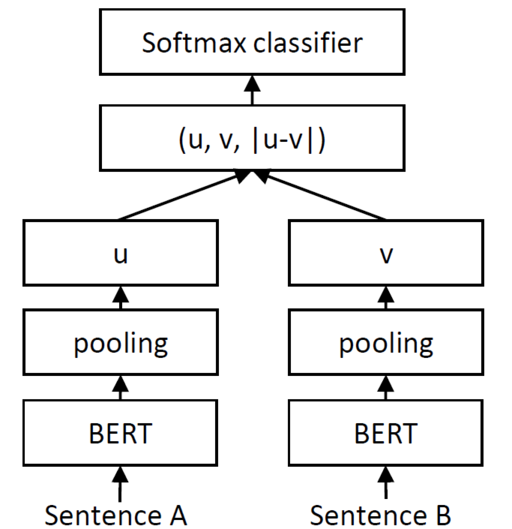

Tasks:

*   **[2 Point]** Prepare a training dataloader and training loop: Read in NLI data, tokenize and generate the corresponding data loader
*   **[2 Point]** BertClassifier: Construct a model that uses above method

**Download NLI dataset**

This dataset includes:
*   Sentence pairs: (sentence1, sentence2)
*   Label: (contradiction, entailment, neutral)
*   Split: train, dev, test

In [ ]:
!wget 'https://sbert.net/datasets/AllNLI.tsv.gz'

--2023-10-02 13:39:53--  https://sbert.net/datasets/AllNLI.tsv.gz
Resolving sbert.net (sbert.net)... 104.21.67.200, 172.67.180.145, 2606:4700:3031::ac43:b491, ...
Connecting to sbert.net (sbert.net)|104.21.67.200|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz [following]
--2023-10-02 13:39:53--  https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/AllNLI.tsv.gz
Resolving public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)... 130.83.167.186
Connecting to public.ukp.informatik.tu-darmstadt.de (public.ukp.informatik.tu-darmstadt.de)|130.83.167.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40794454 (39M) [application/octet-stream]
Saving to: ‘AllNLI.tsv.gz’

AllNLI.tsv.gz       100%[===================>]  38.90M  12.6MB/s    in 3.1s    

2023-10-02 13:39:57 (12

In [ ]:
data = pd.read_csv('AllNLI.tsv.gz', compression='gzip', delimiter='\t', error_bad_lines=False)
data.head()

<ipython-input-14-d6b89082e55c>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('AllNLI.tsv.gz', compression='gzip', delimiter='\t', error_bad_lines=False)
Skipping line 593843: expected 6 fields, saw 7
Skipping line 602994: expected 6 fields, saw 7
Skipping line 644944: expected 6 fields, saw 7

Skipping line 669147: expected 6 fields, saw 7
Skipping line 719671: expected 6 fields, saw 7
Skipping line 727867: expected 6 fields, saw 7
Skipping line 742137: expected 6 fields, saw 7
Skipping line 747285: expected 6 fields, saw 7

Skipping line 790984: expected 6 fields, saw 7
Skipping line 855878: expected 6 fields, saw 7
Skipping line 883143: expected 6 fields, saw 7



,split,dataset,filename,sentence1,sentence2,label
0,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,train,SNLI,snli_1.0_train,Children smiling and waving at camera,They are smiling at their parents,neutral
4,train,SNLI,snli_1.0_train,Children smiling and waving at camera,There are children present,entailment


<Axes: >

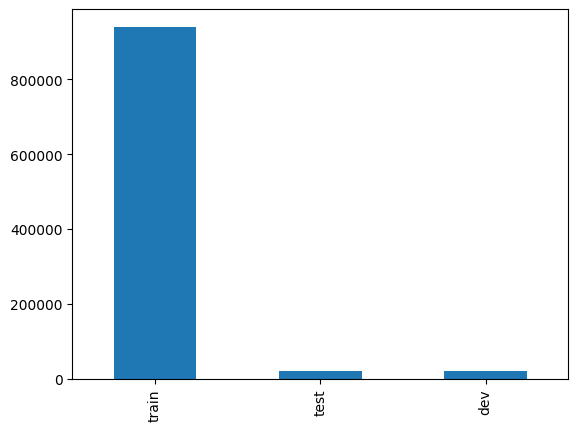

In [ ]:
data['split'].value_counts().plot(kind='bar')

In [ ]:
def load_nli_dataset(file_name) -> dict:
    """
    Load the NLI dataset from a given file.

    Args:
    - file_name (str): The name or path to the NLI dataset file.

    Returns:
    - dict: A dictionary containing the dataset split into 'test', 'train', and 'dev'. Each entry is a list of tuples containing two sentences and their associated label.
    """

    label_mapping = {'neutral': 0, 'contradiction': 1, 'entailment': 2}  # Create a Mapping for Labels


    data = pd.read_csv(file_name, error_bad_lines=False, compression='gzip', delimiter='\t')
    data['label'] = data['label'].map(label_mapping)  # Convert string labels to integers

    test_data = data.loc[data['split'] == 'test']  # get relevant portions
    train_data = data.loc[data['split'] == 'train']
    dev_data = data.loc[data['split'] == 'dev']


    nli_samples = {
      'test': list(test_data[['sentence1', 'sentence2', 'label']].itertuples(index=False, name=None)),  # itertuples for making pairs
      'train': list(train_data[['sentence1', 'sentence2', 'label']].itertuples(index=False, name=None)),
      'dev': list(train_data[['sentence1', 'sentence2', 'label']].itertuples(index=False, name=None))

    }

    return nli_samples


def train_loop(model, optimizer, train_dataloader, validation_dataloader, num_epochs, device):
    """
    Training loop for NLI tasks with validation.

    Args:
    - model (nn.Module): PyTorch model to be trained.
    - optimizer (torch.optim.Optimizer): Optimizer used during training.
    - train_dataloader (DataLoader): DataLoader for the training data.
    - validation_dataloader (DataLoader): DataLoader for the validation data.
    - num_epochs (int): Number of epochs to train the model.
    - device (torch.device): Device (CPU or CUDA) to which the model and data should be transferred before training.

    Returns:
    - tuple: Lists of training and validation losses for each epoch.
    """

    model.to(device)
    criterion = nn.CrossEntropyLoss()  # for classification

    # these are for plotting in task 5 so we are storing stats
    training_loss_per_epoch = []
    validation_loss_per_epoch = []


    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        correct_predictions = 0
        total_predictions = 0
        total_loss = 0

        for batch in train_dataloader:
            tokenized_sentence1, tokenized_sentence2, labels = batch
            tokenized_sentence1 = {k: v.squeeze(dim=1).to(device) for k, v in tokenized_sentence1.items()}  # Removing the extra dimension from each value of the key
            tokenized_sentence2 = {k: v.squeeze(dim=1).to(device) for k, v in tokenized_sentence2.items()}

            labels = torch.tensor(labels).long().to(device)  # Labels are to be in LONG as per pytorch document

            optimizer.zero_grad()
            logits = model(tokenized_sentence1, tokenized_sentence2, labels)  # get raw logits from model
            loss = criterion(logits, labels)  # pass raw logits to CE
            total_loss += loss.item()  # add the loss to total losss

            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted = torch.max(logits, dim=1)  # for acc, get the max pred
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()  # where predicted max pred is equal to label, it is correct

        train_accuracy = 100 * correct_predictions / total_predictions
        print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {total_loss/len(train_dataloader)} - Training Accuracy: {train_accuracy:.2f}%")
        training_loss_per_epoch.append(total_loss/len(train_dataloader))

        # Validation
        model.eval()  # Set model to evaluation mode
        val_total_loss = 0
        val_correct_predictions = 0
        val_total_predictions = 0

        with torch.no_grad():
            for batch in validation_dataloader:
                tokenized_sentence1, tokenized_sentence2, labels = batch
                tokenized_sentence1 = {k: v.squeeze(dim=1).to(device) for k, v in tokenized_sentence1.items()}
                tokenized_sentence2 = {k: v.squeeze(dim=1).to(device) for k, v in tokenized_sentence2.items()}
                labels = torch.tensor(labels).long().to(device)

                logits = model(tokenized_sentence1, tokenized_sentence2, labels)
                loss = criterion(logits, labels)
                val_total_loss += loss.item()

                # Calculate validation accuracy
                _, predicted = torch.max(logits, dim=1)
                val_total_predictions += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

            val_accuracy = 100 * val_correct_predictions / val_total_predictions
            print(f"Epoch {epoch + 1}/{num_epochs} - Validation Loss: {val_total_loss/len(validation_dataloader)} - Validation Accuracy: {val_accuracy:.2f}%")
            validation_loss_per_epoch.append(val_total_loss/len(validation_dataloader))

    return training_loss_per_epoch, validation_loss_per_epoch


class BertClassifier(nn.Module):
    def __init__(self, bert_model, hidden_size, num_labels):
        """
        Initialize the BertClassifier model.

        Args:
        - bert_model (nn.Module): Pretrained BERT model or its variant.
        - hidden_size (int): Size of the hidden layer in BERT.
        - num_labels (int): Number of output labels.
        """
        super(BertClassifier, self).__init__()

        self.bert = bert_model
        self.classifier = nn.Linear(hidden_size * 3, num_labels)  # u, v, |u-v| so we *3


    #  Mean Pooling - Take attention mask into account for correct averaging
    def mean_pooling(self, model_output, attention_mask):
        """
        From the Sentence Embeddings page: https://www.sbert.net/examples/applications/computing-embeddings/README.html#sentence-embeddings-with-transformers

        Perform mean pooling on the model output considering the attention mask.
        Args:
        - model_output (tuple): Output from the BERT model.
        - attention_mask (torch.Tensor): Mask to avoid considering padding tokens.

        Returns:
        - torch.Tensor: Mean pooled token embeddings.

        """
        token_embeddings = model_output[0] #  First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()  # Expand the attention mask for multiplication
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask


    def forward(self, tokenized_sentence1, tokenized_sentence2, labels=None):
        """
        Forward pass both sentence 1 and sentence 2
        Get the Mean Pooling for both with the attention mask. Why Mean Pooling, because in the paper, they said it performs the best
        Perform the concatenation with (u, v, |u-v|) this gave best results in the paper and was in the figure1
        Return Raw Logits as nn.CrossEntropy will take care of softmax

        Args:
        - tokenized_sentence1 (dict): Tokenized and encoded version of the first sentence.
        - tokenized_sentence2 (dict): Tokenized and encoded version of the second sentence.
        - labels (torch.Tensor, optional): True labels for the input sentences.

        Returns:
        - torch.Tensor: Raw logits from the classifier.
        """
        output1 = self.bert(**tokenized_sentence1)
        output2 = self.bert(**tokenized_sentence2)

        u = self.mean_pooling(output1, tokenized_sentence1['attention_mask'])
        v = self.mean_pooling(output2, tokenized_sentence2['attention_mask'])

        features = torch.cat((u, v, torch.abs(u - v)), dim=1)  # Concatenating u, v, |u-v| as per paper
        logits = self.classifier(features)  # dense layer or W matrix as in paper

        return logits  # return raw logits

    def get_embeddings(self, tokenized_sentence1, tokenized_sentence2):
        """
        Get embeddings for both sentences without passing through the classifier.

        Args:
        - tokenized_sentence1 (dict): Tokenized and encoded version of the first sentence.
        - tokenized_sentence2 (dict): Tokenized and encoded version of the second sentence.

        Returns:
        - tuple: Mean pooled embeddings for both sentences.
        """
        output1 = self.bert(**tokenized_sentence1)
        output2 = self.bert(**tokenized_sentence2)

        u = self.mean_pooling(output1, tokenized_sentence1['attention_mask'])  # We use attention mask to calculate the mean pooling
        v = self.mean_pooling(output2, tokenized_sentence2['attention_mask'])

        return u, v

**Training**

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
num_labels = 3
hidden_size = 256
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("DEVICE: ", device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#INFO: load nli dataset
nli_dataset = load_nli_dataset('AllNLI.tsv.gz')

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence length of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)
tokenized_eval = tokenize_sentence_pair_dataset(nli_dataset['test'], tokenizer, max_length=128)

#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size, shuffle=True)
eval_dataloader = get_dataloader(tokenized_test, batch_size=batch_size, shuffle=True)


#TODO: Create a BertClassifier with required parameters
bert = Bert(bert_config).load_model(bert_path)
bert_classifier = BertClassifier(bert, bert_config['hidden_size'], num_labels)

bert_classifier = bert_classifier.to(device)

optimizer = AdamW(bert_classifier.parameters(), lr=5e-5)
siamese_training_loss_per_epoch, siamese_validation_loss_per_epoch = train_loop(bert_classifier, optimizer, train_dataloader, eval_dataloader, num_epochs, device)

DEVICE:  cuda


<ipython-input-108-c4549f9d72a0>:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(file_name, error_bad_lines=False, compression='gzip', delimiter='\t')
Skipping line 593843: expected 6 fields, saw 7
Skipping line 602994: expected 6 fields, saw 7
Skipping line 644944: expected 6 fields, saw 7

Skipping line 669147: expected 6 fields, saw 7
Skipping line 719671: expected 6 fields, saw 7
Skipping line 727867: expected 6 fields, saw 7
Skipping line 742137: expected 6 fields, saw 7
Skipping line 747285: expected 6 fields, saw 7

Skipping line 790984: expected 6 fields, saw 7
Skipping line 855878: expected 6 fields, saw 7
Skipping line 883143: expected 6 fields, saw 7



Loading BERT Weights from:  bert_tiny.bin


<ipython-input-108-c4549f9d72a0>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)  # Labels are to be in LONG as per pytorch document


Epoch 1/3 - Training Loss: 0.875208170633316 - Training Accuracy: 59.08%


<ipython-input-108-c4549f9d72a0>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).long().to(device)


Epoch 1/3 - Validation Loss: 1.0879006285887922 - Validation Accuracy: 50.40%
Epoch 2/3 - Training Loss: 0.7107963156414032 - Training Accuracy: 69.73%
Epoch 2/3 - Validation Loss: 1.2368630835775696 - Validation Accuracy: 46.48%
Epoch 3/3 - Training Loss: 0.6300320080256462 - Training Accuracy: 74.03%
Epoch 3/3 - Validation Loss: 1.518511288427893 - Validation Accuracy: 31.83%


**Evaluation**

Expected result:

Pearson correlation: 0.37

Spearman correlation: 0.42

In [ ]:
result_from_classification, siamese_stats = eval_loop(bert_classifier.bert, test_dataloader, device)  # We pass the BERT model to eval loop i.e bert_classifier.bert = BERT Model Class but fine-tuned in our way. Here the test_dataloader is the STS test loader
print(f'\nPearson correlation: {result_from_classification[0]:.2f}\nSpearman correlation: {result_from_classification[1]:.2f}')


Pearson correlation: 0.54
Spearman correlation: 0.57


# **Coding Challenge Part 4: Learning sentence embedding using a contrastive approach based on NLI dataset [3 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

In this part, you are asked to explore another method that leverages a contrastive approach using NLI dataset.

Tasks **[3 Points]** :

*   Generate a dataloader if this is required for your approach
*   Construct a BERT based model using a contrastive method

In [ ]:
#TODO: add code to load NLI dataset in required format
 ###    if load_nli_dataset(..) is not appropriate for your method

class NLITripletDataset(torch.utils.data.Dataset):
    """
    Dataset class to handle NLI triplet data. Each triplet consists of an anchor, a positive (entailment) example,
    a negative (contradiction) example, and a neutral example.

    For instance:
    Anchor: 'This church choir sings to the masses...'
    Positive (Entailment): 'The church is filled with song.'
    Negative (Contradiction): 'A choir singing at a baseball game.'
    Neutral: 'The church has cracks in the ceiling.'
    """

    def __init__(self, tokenized_triplets):
        """
        Initializes the NLITripletDataset.

        Args:
        - tokenized_triplets (list): List of tokenized triplets where each triplet
          contains an anchor, positive, negative, and neutral sample.
        """
        self.tokenized_triplets = tokenized_triplets

    def __len__(self) -> int:
        """Returns the total number of triplets."""
        return len(self.tokenized_triplets)

    def __getitem__(self, index):
        """
        Returns the triplet at the specified index.

        Args:
        - index (int): Index of the desired triplet.

        Returns:
        - tuple: The specified triplet in the form (anchor, positive, negative, neutral).

        Example:
        ('This church choir sings to the masses as they sing joyous songs from the book at a church.',  # This is ANCHOR, i.e 0 index
        'The church has cracks in the ceiling.',
        'neutral'),  index is [0][0] for sentence, [0][1] for neutral
        ('This church choir sings to the masses as they sing joyous songs from the book at a church.',
          'The church is filled with song.',
          'entailment'),  index is [1][1] for entailment
        ('This church choir sings to the masses as they sing joyous songs from the book at a church.',
          'A choir singing at a baseball game.',
          'contradiction'), index is [2][1] for contradiction
        """
        anchor = self.tokenized_triplets[index][0][0]  # sentence1 of the triplet
        positive = self.tokenized_triplets[index][1][1]  # entailment example
        negative = self.tokenized_triplets[index][2][1]  # contradiction example
        neutral = self.tokenized_triplets[index][0][1]  # neutral example


        return anchor, positive, negative, neutral


def tokenize_sentence_pair_dataset(dataset, tokenizer, max_length=512) -> List[Tuple]:
    """
    Tokenize sentence pairs separately for BERT and returns them as triplets.

    This function is specifically designed for a dataset where every three consecutive entries
    (e.g., neutral, entailment, contradiction) correspond to the same anchor sentence.

    Args:
    - dataset (list of tuple): A list where each entry is a tuple of the form (sentence1, sentence2, score/label).
    - tokenizer (transformers.Tokenizer): A BERT tokenizer.
    - max_length (int, optional): Maximum length for tokenized sequences. Sequences longer than this will be truncated.

    Returns:
    - list of tuple: A list of tokenized sentence triplets. Each triplet contains tokenized versions of
      three consecutive entries from the input dataset.
    """

    tokenized_dataset = []
    for sample in dataset:
        sentence1, sentence2, score = sample
        tokenized_sentence1 = tokenizer(sentence1, return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)
        tokenized_sentence2 = tokenizer(sentence2, return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)
        tokenized_dataset.append((tokenized_sentence1, tokenized_sentence2, torch.tensor(score)))

    # Make it triplet of 3 since each 3 is pair
    triplets = [(tokenized_dataset[i], tokenized_dataset[i+1], tokenized_dataset[i+2]) for i in range(0, len(tokenized_dataset)-2, 3)]  # Since we know that every 3 consec example in the dataset is a pair, so I pair them like this.

    return triplets


def load_nli_dataset(file_path):
    """
    Load the NLI dataset from a given file.

    Args:
    - file_name (str): The name or path to the NLI dataset file.

    Returns:
    - dict: A dictionary containing the dataset split into 'test', 'train', and 'dev'. Each entry is a list of tuples containing two sentences and their associated label.
    """

    label_mapping = {"neutral": 0, "contradiction": 1, "entailment": 2}  # mapp the labels
    data = pd.read_csv(
        file_path, error_bad_lines=False, compression="gzip", delimiter="\t"
    )
    data = data.dropna()  # drop any null row

    data["label"] = data["label"].map(label_mapping)

    return {
        "train": list(data.loc[data["split"] == "train"][['sentence1', 'sentence2', 'label']].itertuples(index=False, name=None)),  # make it tuple of each row i.e [(sen1, sen2, label), ........]
        "test": list(data.loc[data["split"] == "test"][['sentence1', 'sentence2', 'label']].itertuples(index=False, name=None)),
        "dev": list(data.loc[data["split"] == "dev"][['sentence1', 'sentence2', 'label']].itertuples(index=False, name=None)),
    }


def get_dataloader(tokenized_dataset, batch_size) -> DataLoader:
    """
    Returns the Data Loader for Triplet Dataset, uses the custom NLITripletDataset

    Args:
    - tokenized_dataset: list of tuple, A list of tokenized sentence triplets. Each triplet contains tokenized versions of
      three consecutive entries from the input dataset
    - batch_size: int, batch size

    Returns:
    - DataLoader
    """
    return DataLoader(NLITripletDataset(tokenized_dataset), batch_size=batch_size)


class BertContrastive(nn.Module):
    """
    A neural network model leveraging BERT for producing contrastive embeddings.

    This model uses mean pooling over the last layer of BERT to generate embeddings for a given sentence.

    Attributes:
    - bert (transformers.Model): The BERT model used for encoding.

    Methods:
    - mean_pooling(model_output, attention_mask): Computes mean pooled embeddings using the given BERT model output and attention mask.
    - forward(tokenized_sentence): Computes embeddings for a given tokenized sentence.
    """
    def __init__(self, bert_model):
        """
        Initialize the BertContrastive model.

        Args:
        - bert_model (transformers.Model): A pretrained BERT model.
        """
        super(BertContrastive, self).__init__()
        self.bert = bert_model


    def mean_pooling(self, model_output, attention_mask) -> torch.Tensor:
        """
        From the Sentence Embeddings page: https://www.sbert.net/examples/applications/computing-embeddings/README.html#sentence-embeddings-with-transformers

        Perform mean pooling on the model output considering the attention mask.
        Args:
        - model_output (tuple): Output from the BERT model.
        - attention_mask (torch.Tensor): Mask to avoid considering padding tokens.

        Returns:
        - torch.Tensor: Mean pooled token embeddings.
        """
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, tokenized_sentence) -> torch.Tensor:
        """
        Computes embeddings for a given tokenized sentence using BERT and mean pooling.

        Args:
        - tokenized_sentence (dict): Tokenized sentence with keys 'input_ids', 'attention_mask', etc.

        Returns:
        - torch.Tensor: Contrastive embeddings for the given sentence.
        """
        output = self.bert(**tokenized_sentence)
        embeddings = self.mean_pooling(output, tokenized_sentence['attention_mask'])
        return embeddings


def train_loop(model, optimizer, train_dataloader, eval_dataloader, device, num_epochs) -> Tuple[List, List]:
    """
    Training loop for a given model using the TripletMarginLoss.

    This function handles the training and evaluation loops for models, using the
    TripletMarginLoss which expects anchor, positive, and negative examples.

    Args:
    - model (nn.Module): Model to be trained.
    - optimizer (torch.optim.Optimizer): Optimizer for training.
    - train_dataloader (torch.utils.data.DataLoader): DataLoader for training data.
    - eval_dataloader (torch.utils.data.DataLoader): DataLoader for evaluation data.
    - device (torch.device): Device (cuda or cpu) where the model will be trained.
    - num_epochs (int): Number of training epochs.

    Returns:
    - tuple: Contains training and validation losses for each epoch.
    """

    model.to(device)
    criterion = nn.TripletMarginLoss(margin=1.0)  # This Triplet Margin Loss is most common for Contrastive Purposes

    training_loss_per_epoch = []
    val_loss_per_epoch = []
    for epoch in range(num_epochs):
        total_train_loss = 0

        for batch in train_dataloader:
            anchor, positive, negative, _ = batch  # The triplet loss takes 3 pairs so I am ignoring neutral for now, There can be better ways to deal with it such as treating neutral as negative or so. Most of the code for training loop is same as above

            anchor = {k: v.squeeze(dim=1).to(device) for k, v in anchor.items()}
            positive = {k: v.squeeze(dim=1).to(device) for k, v in positive.items()}
            negative = {k: v.squeeze(dim=1).to(device) for k, v in negative.items()}

            anchor_embeddings = model(anchor)  #  get all the embeddings required
            positive_embeddings = model(positive)
            negative_embeddings = model(negative)

            loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
            total_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {total_train_loss/len(train_dataloader)}")
        training_loss_per_epoch.append(total_train_loss/len(train_dataloader))

        # Evaluation
        model.eval()
        total_eval_loss = 0

        with torch.no_grad():
            for batch in eval_dataloader:
                anchor, positive, negative, _ = batch  # mostly same as above
                anchor = {k: v.squeeze(dim=1).to(device) for k, v in anchor.items()}
                positive = {k: v.squeeze(dim=1).to(device) for k, v in positive.items()}
                negative = {k: v.squeeze(dim=1).to(device) for k, v in negative.items()}

                anchor_embeddings = model(anchor)
                positive_embeddings = model(positive)
                negative_embeddings = model(negative)

                loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
                total_eval_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs} - Eval Loss: {total_eval_loss/len(eval_dataloader)}")
        val_loss_per_epoch.append(total_eval_loss/len(eval_dataloader))

    return training_loss_per_epoch, val_loss_per_epoch

**Training**

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
train_batch_size = 8
num_labels =3
hidden_size = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#WARNING: Change this code if you implemented a different nli loader for this part
nli_dataset = load_nli_dataset('AllNLI.tsv.gz')

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence lenght of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)
tokenized_eval = tokenize_sentence_pair_dataset(nli_dataset['test'], tokenizer, max_length=128)

#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=train_batch_size)
eval_dataloader = get_dataloader(tokenized_eval, batch_size=train_batch_size)

#TODO: Create a BertContrastive with required parameters
###    Replace None with required input based on yor implementation
bert = Bert(bert_config).load_model(bert_path).to(device)
bert_contrastive = BertContrastive(bert).to(device)

# #INFO: create optimizer and run training loop
optimizer = AdamW(bert_contrastive.parameters(), lr=5e-5)
contrastive_training_loss_per_epoch, contrastive_val_loss_per_epoch = train_loop(bert_contrastive, optimizer, train_dataloader, eval_dataloader, device, num_epochs)

<ipython-input-102-2f403b920647>:52: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(
Skipping line 593843: expected 6 fields, saw 7
Skipping line 602994: expected 6 fields, saw 7
Skipping line 644944: expected 6 fields, saw 7

Skipping line 669147: expected 6 fields, saw 7
Skipping line 719671: expected 6 fields, saw 7
Skipping line 727867: expected 6 fields, saw 7
Skipping line 742137: expected 6 fields, saw 7
Skipping line 747285: expected 6 fields, saw 7

Skipping line 790984: expected 6 fields, saw 7
Skipping line 855878: expected 6 fields, saw 7
Skipping line 883143: expected 6 fields, saw 7



Loading BERT Weights from:  bert_tiny.bin
Epoch 1/3 - Training Loss: 0.8973738759927695
Epoch 1/3 - Eval Loss: 0.9242116199562983
Epoch 2/3 - Training Loss: 0.8094780980725549
Epoch 2/3 - Eval Loss: 0.9086988283018781
Epoch 3/3 - Training Loss: 0.6869965432186731
Epoch 3/3 - Eval Loss: 0.9405045077040955


**Evaluation**

In [ ]:
#TODO: run evaluation loop
result_from_contrastive, contrastive_stats = eval_loop(bert_contrastive.bert, test_dataloader, device)
print(f'\nPearson correlation: {result_from_contrastive[0]:.2f}\nSpearman correlation: {result_from_contrastive[1]:.2f}')


Pearson correlation: 0.26
Spearman correlation: 0.27


# **Coding Challenge Part 5: Comparison [1 Point]**

In the final part of the coding challenge, you are asked to compare the result of pretrained BERT, classification based BERT, and contrastive method based BERT.

These are the tasks **[1 Point]**:


*   Plot the result for each model
*   Explain the difference between methods and their impact on the result and comparison

[ANSWER 2 CELLs BELOW]

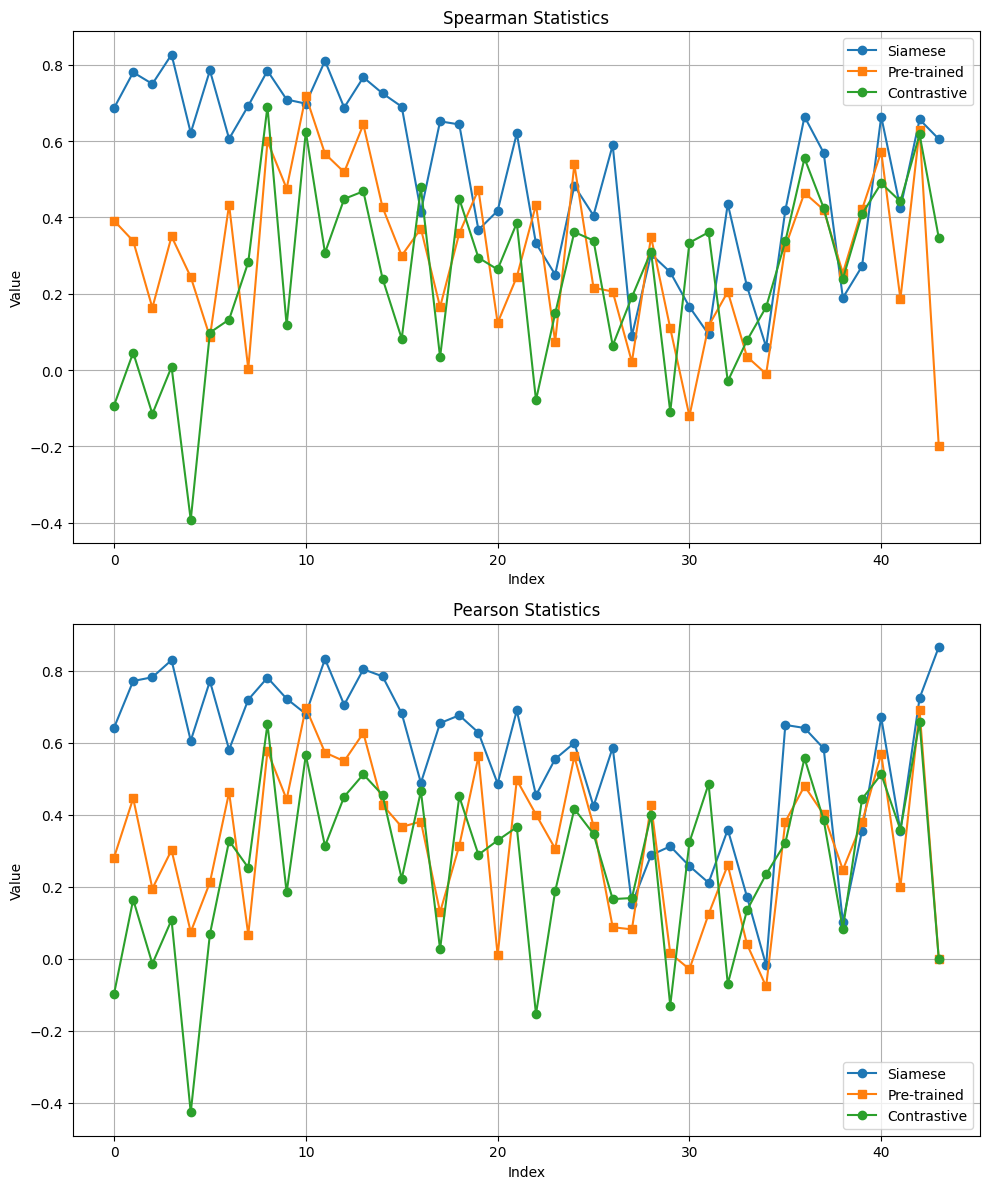

In [ ]:
import matplotlib.pyplot as plt

siamese_spearman, siamese_pearson = siamese_stats
pre_trained_spearman, pre_trained_pearson = pre_trained_stats
contrastive_spearman, contrastive_pearson = contrastive_stats

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,12))

# Plotting Spearman statistics
ax1.plot(siamese_spearman, label='Siamese', linestyle='-', marker='o')
ax1.plot(pre_trained_spearman, label='Pre-trained', linestyle='-', marker='s')
ax1.plot(contrastive_spearman, label='Contrastive', linestyle='-', marker='o')
ax1.set_title('Spearman Statistics')
ax1.set_xlabel('Index')
ax1.set_ylabel('Value')
ax1.legend()
ax1.grid(True)

# Plotting Pearson statistics
ax2.plot(siamese_pearson, label='Siamese', linestyle='-', marker='o')
ax2.plot(pre_trained_pearson, label='Pre-trained', linestyle='-', marker='s')
ax2.plot(contrastive_pearson, label='Contrastive', linestyle='-', marker='o')
ax2.set_title('Pearson Statistics')
ax2.set_xlabel('Index')
ax2.set_ylabel('Value')
ax2.legend()
ax2.grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()  # From the figure, Siamese gives the best results on spearman and pearson both

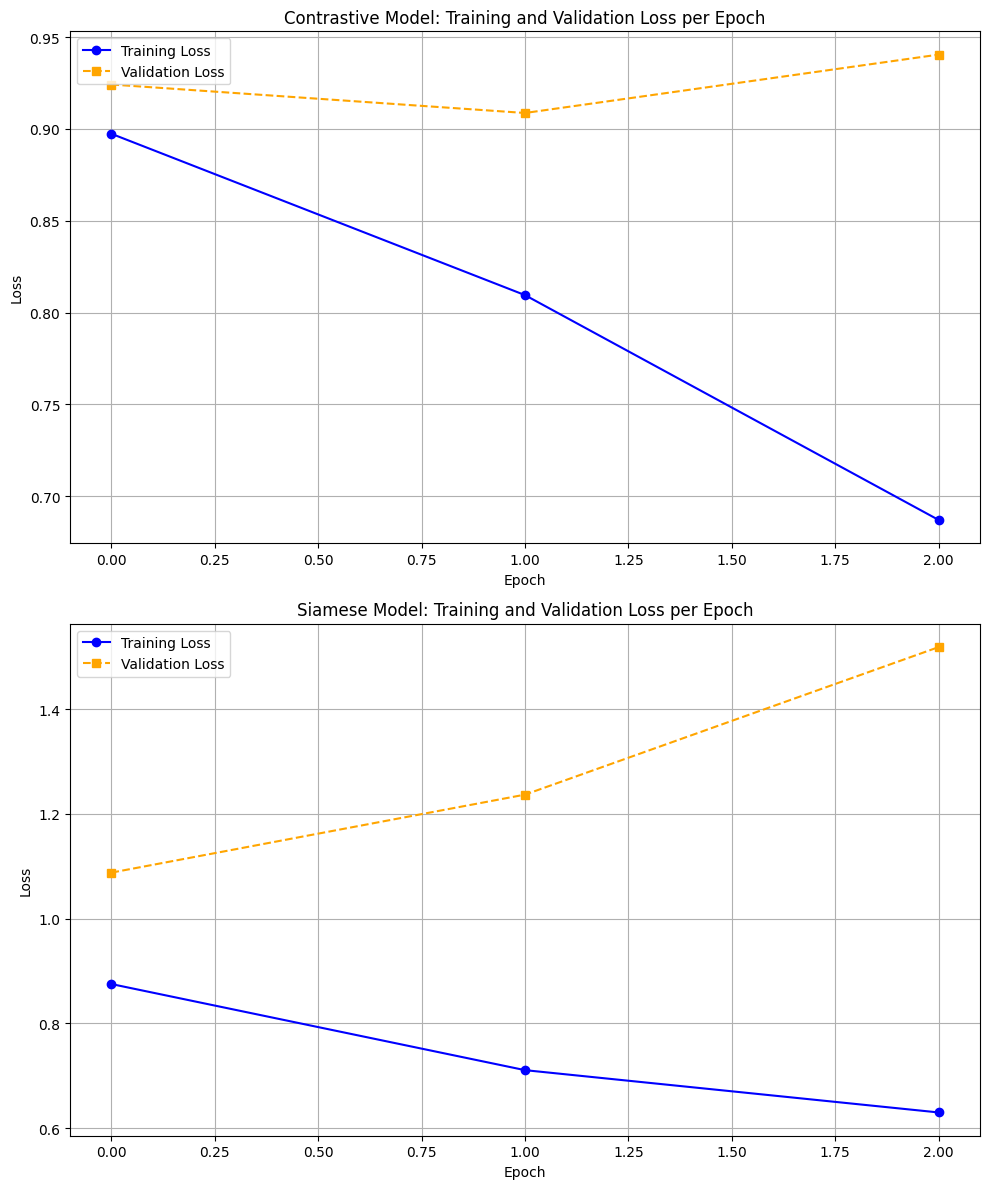

In [ ]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,12))

# Plotting Contrastive losses
ax1.plot(contrastive_training_loss_per_epoch, label='Training Loss', linestyle='-', marker='o', color='blue')
ax1.plot(contrastive_val_loss_per_epoch, label='Validation Loss', linestyle='--', marker='s', color='orange')
ax1.set_title('Contrastive Model: Training and Validation Loss per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plotting Siamese losses
ax2.plot(siamese_training_loss_per_epoch, label='Training Loss', linestyle='-', marker='o', color='blue')
ax2.plot(siamese_validation_loss_per_epoch, label='Validation Loss', linestyle='--', marker='s', color='orange')
ax2.set_title('Siamese Model: Training and Validation Loss per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()


In [ ]:
"""
Answer to the Question: Explain the difference between methods and their impact on the result and comparison

Ans:
1. The Siamese Bert or BertClassifier model that we have used fine-tunes the pre-trained bert model further. The NLI dataset has positive, negative, neutral classes.
One way to do is that we train a classifier on top of BERT, but in such a way that it has information of both sentences. In the SBERT paper, they explore that if you combine the
embeddings like (u, v, |u-v|) where u and v are embeddings of sent1 and sent2 respectively from bert and mean pooling, and then perform classification, results are really good. I think of
CrossEntropy as Energy Based here as Yann LeCun has also mentioned it in his Tweets. We minimize the Energy of related labels and maximize the Energy of oposite labels. This
gives really good representations as we have seen, SBERT crosses all of the above methods.

2. Contrastive BERT is where we take use of a different approach then classification. The idea is similar that we minimize the energy of related (or minimize the diff b.w them) and maximize
the energy of unrelated labels. The goal is that we use sentence, it's positive pair, it's negative pair and use the triplet loss which brings positive and anchor close, negative and anchor
far away. This helps us learn good representations. There are many advanced contrastive losses such as NTXent Loss. We can extend the functionality to add Neutral pairs which can improve the
model by a good factor. Here this only has worsen the performance of the model.

3. Pre-trained BERT is the original BERT trained by using 2 objectives MLM and Next Sentence Prediction objective. These 2 objectives have let it learned representations well.

Comparison:
- Siamese Bert is the clear winner here. With the simple strategy of nn.CrossEntropy on sentence pairs in supervised fashion help us learn represenations really well.
"""

# **[OPTIONAL] Explore an alternative way to improve sentence encoder in terms of *performance* or *efficiency* [6 Points]**

Potential directions:
*   Improve the methodology to compute higher quality sentence embeddings  
*   Improve the efficiency during fine-tuning in terms of memory or training time
*   Use different machine learning methods that leverages other resources such as auxillary/teacher models
*   Use different datasets with other training objectives


**You can use any additional model, dataset, library or package for this part!!**

In [ ]:
"""
# Improvments:
- High Quality Sentence Embedding.
  - nn.Triplet does not account for Neutral. We can use NTXentLoss loss + Softmax label for Classification
  - We Will combine Both ClassificationBert and ContrastiveBert with same bert in the backbone for amazing representations
- Efficency: We can use lower data types such as float16 or int16
- More Datasets: Jina-Negation is also a  good dataset
- Bigger Batch size works better in contrastive learning. I think collab can only afford 16 in my case
"""

'\n# Improvments:\n- High Quality Sentence Embedding.\n  - nn.Triplet does not account for Neutral. We can use NTXentLoss loss + Softmax label for Classification\n  - We Will combine Both ClassificationBert and ContrastiveBert with same bert in the backbone for amazing representations\n- Efficency: We can use lower data types such as float16 or int16\n- More Datasets: Jina-Negation is also a  good dataset\n- Bigger Batch size works better in contrastive learning. I think collab can only afford 16 in my case\n'

In [ ]:
url = 'https://huggingface.co/datasets/jinaai/negation-dataset/raw/main/negation_training.tsv'

jina_df = pd.read_csv(url, sep='\t')
jina_df.head()  # this can be used for better Contrastive learning

,anchor,entailment,negative
0,Two young girls are playing outside in a non-u...,Two girls are playing outside.,Two girls are not playing outside.
1,A man with a red shirt is watching another man...,A man is standing on top of a cart.,A man is not standing on top of a cart.
2,A man in a blue shirt driving a Segway type ve...,A person is riding a motorized vehicle.,A person is not riding a motorized vehicle.
3,A woman holds her mouth wide open as she is pl...,There is a woman eating crackers.,There is no woman eating crackers.
4,A group of people standing on a rock path.,A group of people are hiking.,A group of people are not hiking.


In [ ]:
jina_df.shape

(10000, 3)

In [ ]:
from itertools import zip_longest

class SiameseContrastiveBERT(nn.Module):
    """
    A Siamese BERT model for contrastive learning.

    This model combines the best from both techniques.
    The embeddings from the BERT models are then combined and passed through a linear classifier.
    Raw Embeddings are used for contrastive learning

    Attributes:
    - bert (nn.Module): The BERT model used for sentence embeddings.
    - classifier (nn.Module): Linear classifier for final decision.
    """

    def __init__(self, bert_model, hidden_size, num_labels):
        """
        Initializes the SiameseContrastiveBERT model.

        Args:
        - bert_model (nn.Module): Pre-trained BERT model.
        - hidden_size (int): Hidden size for the BERT model, determines the dimension of embeddings.
        - num_labels (int): Number of output labels.
        """
        super(SiameseContrastiveBERT, self).__init__()
        self.bert = bert_model
        self.classifier = nn.Linear(hidden_size * 3, num_labels)  # For SiameseBERT

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, tokenized_sentence1, tokenized_sentence2):
        """
        Forward pass for SiameseContrastiveBERT model.

        Args:
        - tokenized_sentence1 (dict): Tokenized version of the first sentence.
        - tokenized_sentence2 (dict): Tokenized version of the second sentence.

        Returns:
        - logits (torch.Tensor): Output logits from the classifier.
        - u (torch.Tensor): Embedding for the first sentence.
        - v (torch.Tensor): Embedding for the second sentence.
        """
        output1 = self.bert(**tokenized_sentence1)
        output2 = self.bert(**tokenized_sentence2)

        u = self.mean_pooling(output1, tokenized_sentence1['attention_mask'])
        v = self.mean_pooling(output2, tokenized_sentence2['attention_mask'])

        # For SiameseBERT
        features = torch.cat((u, v, torch.abs(u - v)), dim=1)
        logits = self.classifier(features)

        return logits, u, v


def combined_train_loop(model, optimizer, siamese_dataloader, contrastive_dataloader, device, num_epochs):
    """
    Train a SiameseContrastiveBERT model using both Siamese and Contrastive losses.

    This function trains the model using a combined loss function derived from both
    Siamese and Contrastive training paradigms. The data loaders are zipped together
    to iterate through them simultaneously.

    Args:
    - model (nn.Module): SiameseContrastiveBERT model.
    - optimizer (torch.optim.Optimizer): Optimizer for model parameters.
    - siamese_dataloader (torch.utils.data.DataLoader): DataLoader for Siamese dataset.
    - contrastive_dataloader (torch.utils.data.DataLoader): DataLoader for Contrastive dataset.
    - device (torch.device): The device on which tensors should be moved before computation.
    - num_epochs (int): Number of training epochs.

    Returns:
    - list: Combined losses for each epoch.
    """

    model.to(device)
    criterion_class = nn.CrossEntropyLoss()
    criterion_contrastive = nn.TripletMarginLoss(margin=1.0)

    combined_loss_per_epoch = []

    # I am giving Siamese more weight since it proved to perform better as per my previous exp
    weight_siamese = 1.0  # Hyperparameter: weight for the Siamese loss
    weight_contrastive = 0.8  # Hyperparameter: weight for the Contrastive loss

    for epoch in range(num_epochs):

        for siamese_batch, contrastive_batch in zip_longest(siamese_dataloader, contrastive_dataloader):

            combined_loss = torch.tensor(0.0, requires_grad=True).to(device)   # Initialize the combined loss with 0

            if siamese_batch:
                tokenized_sentence1, tokenized_sentence2, labels = siamese_batch  # perform the complete siamese operation as we have done in siamese bert
                tokenized_sentence1 = {k: v.squeeze(dim=1).to(device) for k, v in tokenized_sentence1.items()}
                tokenized_sentence2 = {k: v.squeeze(dim=1).to(device) for k, v in tokenized_sentence2.items()}
                labels = labels.long().to(device)
                logits, _, _ = model(tokenized_sentence1, tokenized_sentence2)
                siamese_loss = weight_siamese * criterion_class(logits, labels)  # weight the loss
                combined_loss += siamese_loss  # combine the loss

            if contrastive_batch:
                anchor, positive, negative, _ = contrastive_batch  # perform the complete contrastive operation as we have done in contrastive bert
                anchor = {k: v.squeeze(dim=1).to(device) for k, v in anchor.items()}
                positive = {k: v.squeeze(dim=1).to(device) for k, v in positive.items()}
                negative = {k: v.squeeze(dim=1).to(device) for k, v in negative.items()}
                _, anchor_embeddings, _ = model(anchor, anchor)
                _, positive_embeddings, _ = model(anchor, positive)
                _, negative_embeddings, _ = model(anchor, negative)
                contrastive_loss = weight_contrastive * criterion_contrastive(anchor_embeddings, positive_embeddings, negative_embeddings)
                combined_loss += contrastive_loss

            optimizer.zero_grad()
            combined_loss.backward()
            optimizer.step()

        #Since the Contrastive Data Loader is short in length, because we make pairs of 3, when we do zip_longest loop, it becomes none, so the output is 0.0. It should be changed to store the last contrastive loss.
        print(f"Epoch {epoch + 1}/{num_epochs} - Siamese Loss: {siamese_loss.item() if siamese_batch else 0.0}, Contrastive Loss: {contrastive_loss.item() if contrastive_batch else 0.0}, Combined Loss: {combined_loss.item()}")
        combined_loss_per_epoch.append(combined_loss.item())


    return combined_loss_per_epoch

In [ ]:
# Here I am just copying helper functions from the above tasks for both and renaming them + minor modifications.

def load_nli_dataset_siamese(file_name) -> Dict:
    """
    Load the Natural Language Inference (NLI) dataset and structure it for Siamese networks.

    Given the file name of an NLI dataset, this function reads the data, maps the labels from strings
    to integers, and structures the data in pairs for training, testing, and validation.

    Args:
    - file_name (str): Path to the gzipped NLI dataset file, formatted with columns 'sentence1', 'sentence2', 'label', and 'split'.

    Returns:
    - dict: Dictionary containing sentence pairs and labels for training, testing, and validation.
      E.g., {'train': [(sent1, sent2, label), ...], 'test': [...], 'dev': [...]}.
    """
    label_mapping = {'neutral': 0, 'contradiction': 1, 'entailment': 2}  # mapper

    data = pd.read_csv(file_name, error_bad_lines=False, compression='gzip', delimiter='\t')
    data['label'] = data['label'].map(label_mapping)  # Convert string labels to integers

    test_data = data.loc[data['split'] == 'test']  # get relevant subset
    train_data = data.loc[data['split'] == 'train']
    dev_data = data.loc[data['split'] == 'dev']


    nli_samples = {
      'test': list(test_data[['sentence1', 'sentence2', 'label']].itertuples(index=False, name=None)),
      'train': list(train_data[['sentence1', 'sentence2', 'label']].itertuples(index=False, name=None)),
      'dev': list(train_data[['sentence1', 'sentence2', 'label']].itertuples(index=False, name=None))

    }

    return nli_samples

def load_nli_jina_dataset_contrastive(file_path, url = 'https://huggingface.co/datasets/jinaai/negation-dataset/raw/main/negation_training.tsv'):
    """
    Loads a combined NLI and JINA dataset, and prepares data for a contrastive learning model.

    This function fetches the JINA negation dataset from a URL, combines it with an NLI dataset
    provided via a file path, and structures the data into pairs suitable for training, testing,
    and validation in a contrastive learning setting.

    Args:
    - file_path (str): Path to the NLI dataset file, which should have columns 'sentence1', 'sentence2', 'label', and 'split'.
    - url (str): URL where the JINA dataset can be fetched..

    Returns:
    - dict: Dictionary containing sentence pairs and labels for training, testing, and validation.
      E.g., {'train': [(sent1, sent2, label), ...], 'test': [...], 'dev': [...]}.
    """

    jina_df = pd.read_csv(url, sep='\t')
    jina_combined = []
    for row in jina_df.itertuples(index=False):
        jina_combined.append((row.anchor, row.entailment, 2))  # 'entailment' label is 2
        jina_combined.append((row.anchor, row.negative, 1))    # 'contradiction' label is 1
        jina_combined.append((row.anchor, row.anchor, 0))  # we will ignore this


    label_mapping = {"neutral": 0, "contradiction": 1, "entailment": 2}
    data = pd.read_csv(
        file_path, error_bad_lines=False, compression="gzip", delimiter="\t"
    )
    data = data.dropna()

    data["label"] = data["label"].map(label_mapping)

    return {
        "train": list(data.loc[data["split"] == "train"][['sentence1', 'sentence2', 'label']].itertuples(index=False, name=None)) + jina_combined,  # concat both for training
        "test": list(data.loc[data["split"] == "test"][['sentence1', 'sentence2', 'label']].itertuples(index=False, name=None)),
        "dev": list(data.loc[data["split"] == "dev"][['sentence1', 'sentence2', 'label']].itertuples(index=False, name=None)),
    }


def tokenize_sentence_pair_dataset_siamese(dataset, tokenizer, max_length=512) -> List[Tuple]:
    """
    Tokenize sentence pairs from the dataset separately using the provided tokenizer.

    This function is useful especially for transformer models like BERT that need sentence pairs tokenized
    in a certain way. Each sentence in the pair is tokenized separately and returned as individual tensorized
    inputs suitable for BERT-like models.

    Args:
    - dataset (list of tuples): List containing tuples of sentence pairs and their similarity scores.
                                Each tuple has the format (sentence1, sentence2, score).
    - tokenizer (callable): A tokenizer function or object that can tokenize text.
                            It should have a method that accepts parameters like return_tensors, padding,
                            max_length, and truncation.
    - max_length (int, optional): Maximum length for tokenized sequences. Sequences longer than this
                                  will be truncated. Default is 512.

    Returns:
    - list of tuples: List containing tokenized sentence pairs and their scores. Each tuple has the format
                      (tokenized_sentence1, tokenized_sentence2, score_tensor).
    """
    tokenized_dataset = []
    for sample in dataset:
        sentence1, sentence2, score = sample
        tokenized_sentence1 = tokenizer(sentence1, return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)
        tokenized_sentence2 = tokenizer(sentence2, return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)
        tokenized_dataset.append((tokenized_sentence1, tokenized_sentence2, torch.tensor(score)))
    return tokenized_dataset


def tokenize_sentence_pair_dataset_contrastive(dataset, tokenizer, max_length=512) -> List[Tuple]:
    """
    Tokenize sentence pairs separately for BERT and returns them as triplets.

    This function is specifically designed for a dataset where every three consecutive entries
    (e.g., neutral, entailment, contradiction) correspond to the same anchor sentence.

    Args:
    - dataset (list of tuple): A list where each entry is a tuple of the form (sentence1, sentence2, score/label).
    - tokenizer (transformers.Tokenizer): A BERT tokenizer.
    - max_length (int, optional): Maximum length for tokenized sequences. Sequences longer than this will be truncated.

    Returns:
    - list of tuple: A list of tokenized sentence triplets. Each triplet contains tokenized versions of
      three consecutive entries from the input dataset.
    """
    tokenized_dataset = []
    for sample in dataset:
        sentence1, sentence2, score = sample
        tokenized_sentence1 = tokenizer(sentence1, return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)
        tokenized_sentence2 = tokenizer(sentence2, return_tensors='pt', padding='max_length', max_length=max_length, truncation=True)
        tokenized_dataset.append((tokenized_sentence1, tokenized_sentence2, torch.tensor(score)))

    # Make it triplet of 3 since each 3 is pair
    triplets = [(tokenized_dataset[i], tokenized_dataset[i+1], tokenized_dataset[i+2]) for i in range(0, len(tokenized_dataset)-2, 3)]

    return triplets

def get_dataloader_contrastive(tokenized_dataset, batch_size) -> DataLoader:
    """
    Creates and returns a DataLoader for a contrastive learning dataset.

    This function takes a pre-tokenized dataset, wraps it into a custom NLITripletDataset
    (which presumably yields triplets of examples for contrastive training), and then returns a DataLoader
    that provides batches of these triplets.

    Args:
    - tokenized_dataset (iterable): Pre-tokenized dataset that is suitable to be fed into the NLITripletDataset.
    - batch_size (int): Size of batches that the DataLoader should yield.

    Returns:
    - DataLoader: DataLoader that yields batches of data triplets for contrastive training.
    """
    return DataLoader(NLITripletDataset(tokenized_dataset), batch_size=batch_size)


def get_dataloader_siamese(tokenized_dataset, batch_size, shuffle=False) -> DataLoader:
    """
    Convert the tokenized dataset into a DataLoader for easy batch processing.

    Args:
    - tokenized_dataset (list): The tokenized dataset containing sentence pairs and scores.
    - batch_size (int): The size of each batch.
    - shuffle (bool): Whether to shuffle the dataset before batching.

    Returns:
    - DataLoader: A DataLoader object containing batches of the tokenized dataset.
    """
    return DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=shuffle)


In [ ]:
bert_path = 'bert_tiny.bin'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_labels = 3
num_epochs = 8

siamese_data = load_nli_dataset_siamese('AllNLI.tsv.gz')
contrastive_data = load_nli_jina_dataset_contrastive('AllNLI.tsv.gz', 'https://huggingface.co/datasets/jinaai/negation-dataset/raw/main/negation_training.tsv')

siamese_tokenized = tokenize_sentence_pair_dataset_siamese(siamese_data['train'][:50000], tokenizer, 128)
contrastive_tokenized = tokenize_sentence_pair_dataset_contrastive(contrastive_data['train'][:50000], tokenizer, 128)

siamese_dataloader = get_dataloader_siamese(siamese_tokenized, 16)  # batch size of 16 can yield better results then batch size of 8 in case of contrastive learning
contrastive_dataloader = get_dataloader_contrastive(contrastive_tokenized, 16)

bert = Bert(bert_config).load_model(bert_path).to(device)

model = SiameseContrastiveBERT(bert, bert_config['hidden_size'], num_labels)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

combined_loss_per_epoch = combined_train_loop(model, optimizer, siamese_dataloader, contrastive_dataloader, device, num_epochs)

<ipython-input-14-511d40111951>:8: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(file_name, error_bad_lines=False, compression='gzip', delimiter='\t')
Skipping line 593843: expected 6 fields, saw 7
Skipping line 602994: expected 6 fields, saw 7
Skipping line 644944: expected 6 fields, saw 7

Skipping line 669147: expected 6 fields, saw 7
Skipping line 719671: expected 6 fields, saw 7
Skipping line 727867: expected 6 fields, saw 7
Skipping line 742137: expected 6 fields, saw 7
Skipping line 747285: expected 6 fields, saw 7

Skipping line 790984: expected 6 fields, saw 7
Skipping line 855878: expected 6 fields, saw 7
Skipping line 883143: expected 6 fields, saw 7

<ipython-input-14-511d40111951>:40: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(
Skipping line 5938

Loading BERT Weights from:  bert_tiny.bin
Epoch 1/8 - Siamese Loss: 0.6840449571609497, Contrastive Loss: 0.0, Combined Loss: 0.6840449571609497
Epoch 2/8 - Siamese Loss: 0.6552565097808838, Contrastive Loss: 0.0, Combined Loss: 0.6552565097808838
Epoch 3/8 - Siamese Loss: 0.6372019052505493, Contrastive Loss: 0.0, Combined Loss: 0.6372019052505493
Epoch 4/8 - Siamese Loss: 0.5732378959655762, Contrastive Loss: 0.0, Combined Loss: 0.5732378959655762
Epoch 5/8 - Siamese Loss: 0.44977208971977234, Contrastive Loss: 0.0, Combined Loss: 0.44977208971977234
Epoch 6/8 - Siamese Loss: 0.44787368178367615, Contrastive Loss: 0.0, Combined Loss: 0.44787368178367615
Epoch 7/8 - Siamese Loss: 0.4156669080257416, Contrastive Loss: 0.0, Combined Loss: 0.4156669080257416
Epoch 8/8 - Siamese Loss: 0.46483442187309265, Contrastive Loss: 0.0, Combined Loss: 0.46483442187309265


In [ ]:
result_from_combined, combined_stats = eval_loop(model.bert, test_dataloader, device)
print(f'\nPearson correlation: {result_from_combined[0]:.2f}\nSpearman correlation: {result_from_combined[1]:.2f}')

# We can see from the results that this score is better then all previous scores. Using both in combination of better data is a good way to learn represenations


Pearson correlation: 0.56
Spearman correlation: 0.58


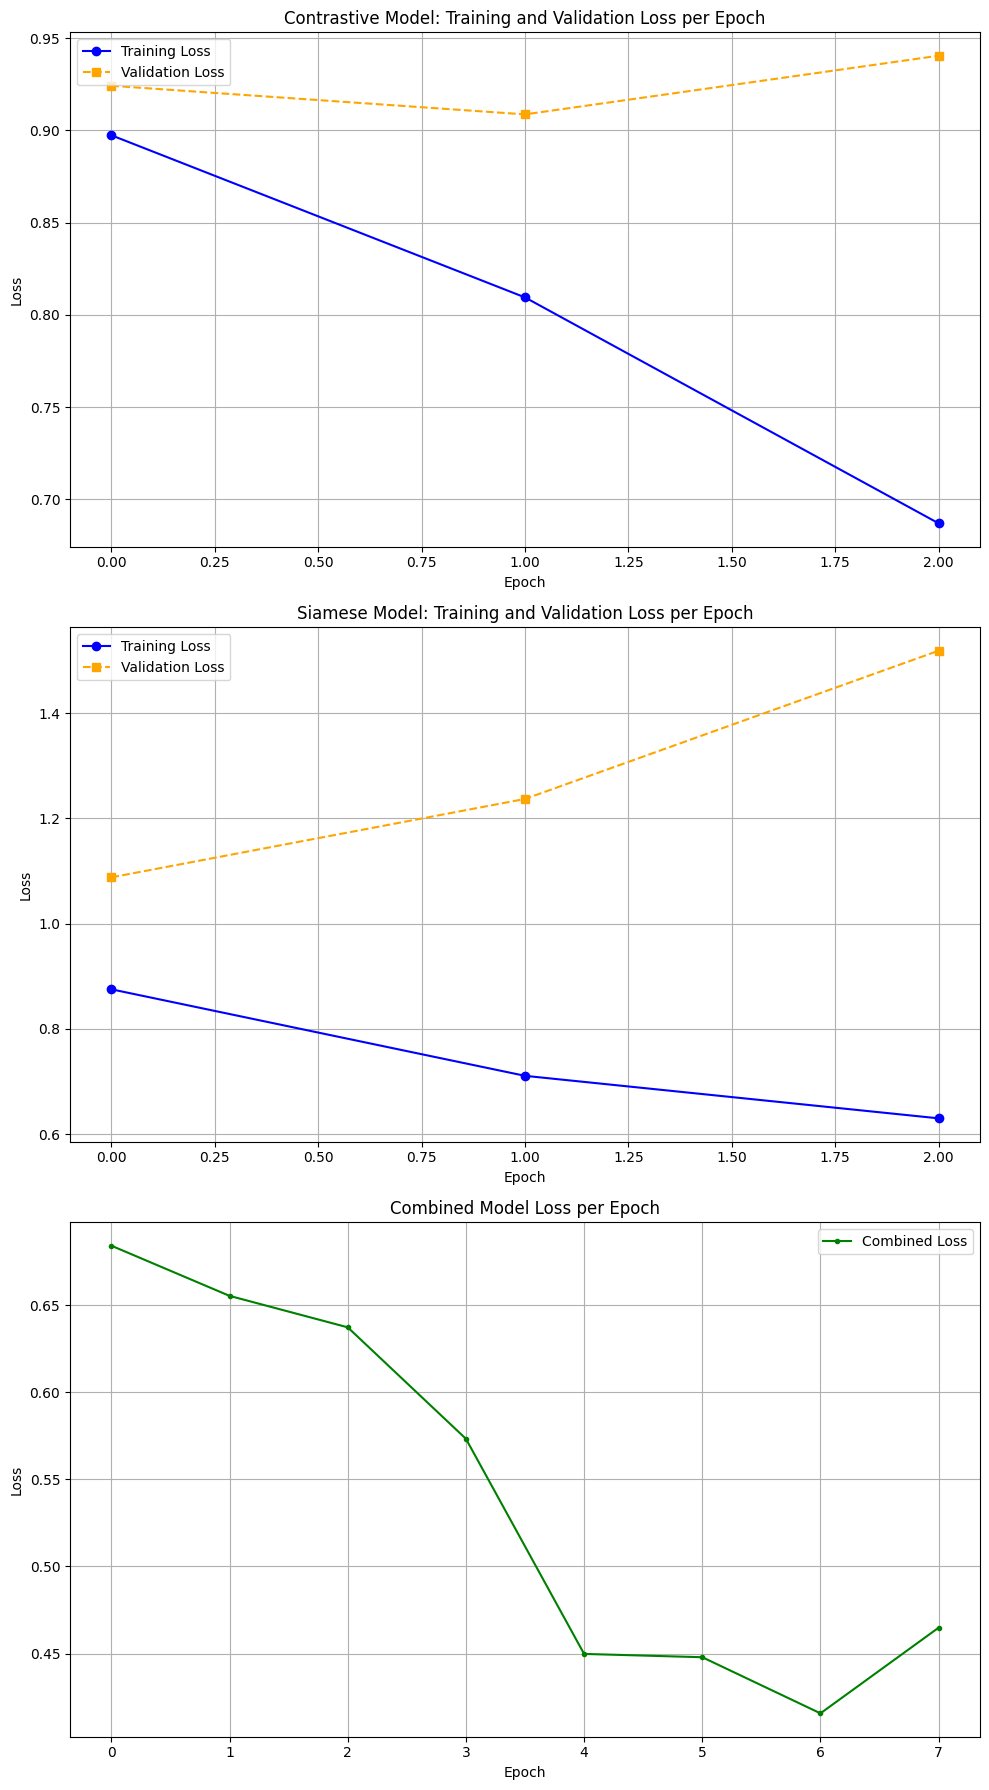

In [ ]:
"""
Plotting results for last part
"""
import matplotlib.pyplot as plt

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,18))

# Plotting Contrastive losses
ax1.plot(contrastive_training_loss_per_epoch, label='Training Loss', linestyle='-', marker='o', color='blue')
ax1.plot(contrastive_val_loss_per_epoch, label='Validation Loss', linestyle='--', marker='s', color='orange')
ax1.set_title('Contrastive Model: Training and Validation Loss per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plotting Siamese losses
ax2.plot(siamese_training_loss_per_epoch, label='Training Loss', linestyle='-', marker='o', color='blue')
ax2.plot(siamese_validation_loss_per_epoch, label='Validation Loss', linestyle='--', marker='s', color='orange')
ax2.set_title('Siamese Model: Training and Validation Loss per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Plotting Combined losses
ax3.plot(combined_loss_per_epoch, label='Combined Loss', linestyle='-', marker='.', color='green')
ax3.set_title('Combined Model Loss per Epoch')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()


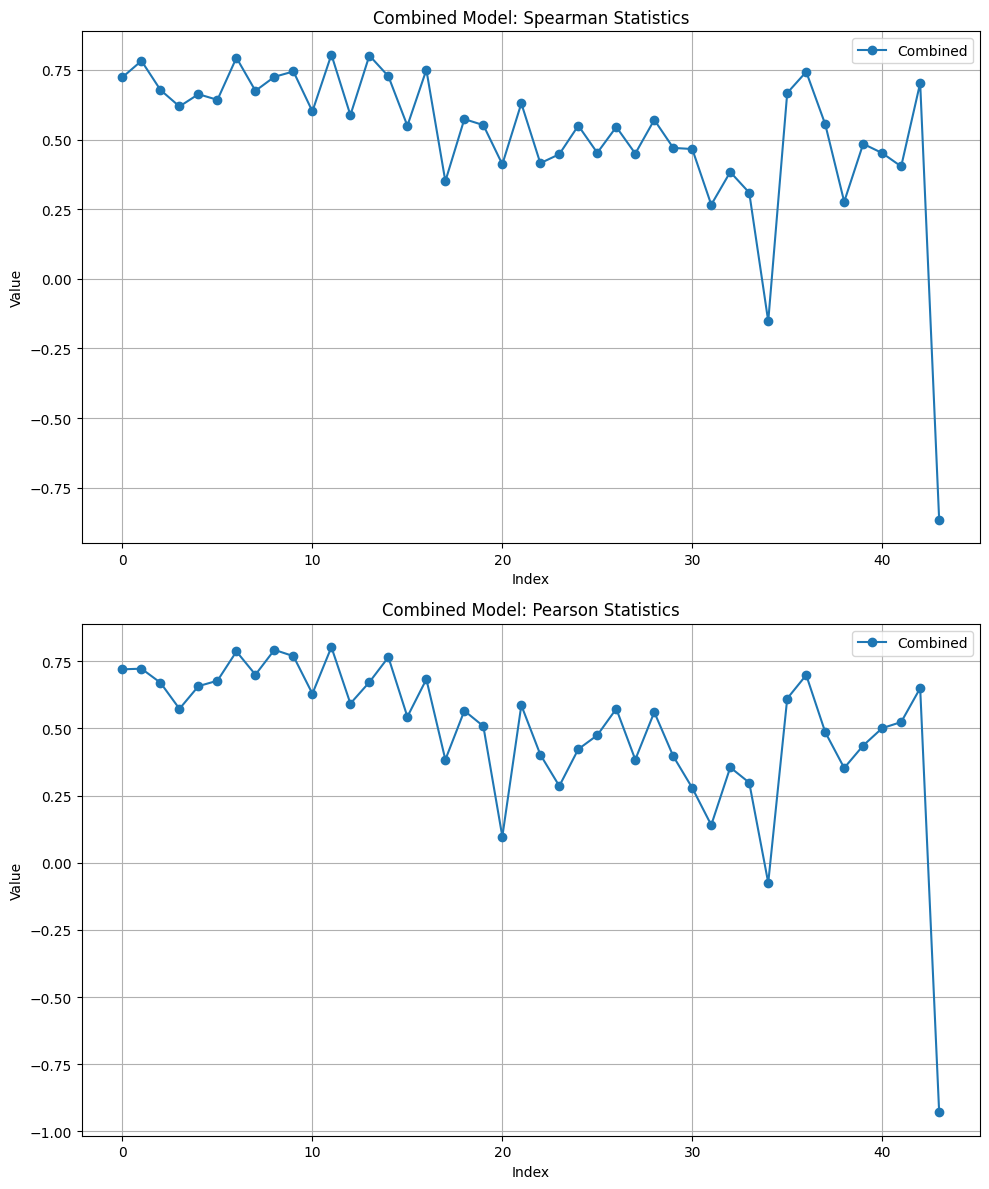

In [ ]:
import matplotlib.pyplot as plt

combined_spearman, combined_pearson = combined_stats  # unpacking combined_stats

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,12))

# Plotting Spearman statistics for combined stats
ax1.plot(combined_spearman, label='Combined', linestyle='-', marker='o')
ax1.set_title('Combined Model: Spearman Statistics')
ax1.set_xlabel('Index')
ax1.set_ylabel('Value')
ax1.legend()
ax1.grid(True)

# Plotting Pearson statistics for combined stats
ax2.plot(combined_pearson, label='Combined', linestyle='-', marker='o')
ax2.set_title('Combined Model: Pearson Statistics')
ax2.set_xlabel('Index')
ax2.set_ylabel('Value')
ax2.legend()
ax2.grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()
